# Ca channels: recovery from inactivation

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ca channel recordings in the "data/Ca_channels" folder

In [24]:
data_folder = "data/3-Ca_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/3-Ca_channels


['data/3-Ca_channels/2025_06_09_0008.abf',
 'data/3-Ca_channels/2025_06_09_0009.abf',
 'data/3-Ca_channels/CAV_Tho_IV.abf',
 'data/3-Ca_channels/2025_06_09_0002.abf',
 'data/3-Ca_channels/2024_06_10_0027.abf']

Choose which file you want to analyze and past the file name here:

In [37]:
data_file = 'data/3-Ca_channels/2025_06_09_0009.abf'

Now we can load the file and plot the raw data:

Trace('2025_06_09_0009.abf')
Number of sweeps: 26
Points per sweep: 60,000
Duration per sweep: 6.000 s
Sampling rate: 10000 Hz
Sampling interval: 0.100 ms
Available channels: Current, Voltage, TTL


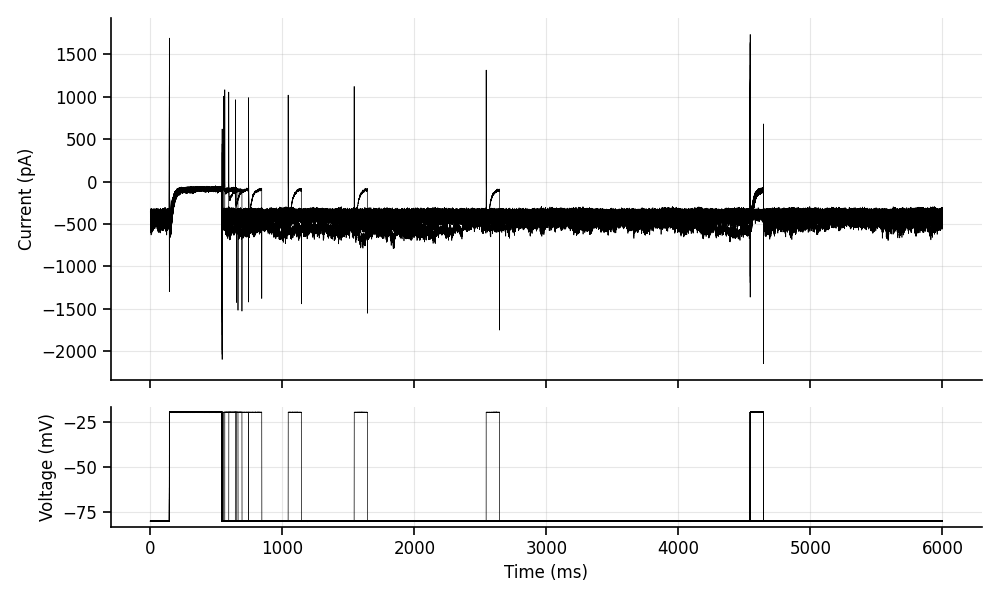

In [38]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=True,
                              units=['pA', 'mV', 'V'], 
                              concatenate_sweeps=False)
print(traces)

time_units = 'ms'

# ----------------------------------------------------------------------------------------------------------------
%matplotlib widget
traces.plot(plot_voltage=True, 
            time_units=time_units, 
            sweep='all')  # Options: 'all', or enter a number here if you want to plot individual sweeps
plt.show()

## 2. Signal processing

## 2. Select what you want to measure

### 2.1. Defining the time window

First let's define the relevant time window where we want to measure the currents:

(If you want to save the images, you can do it by clicking on the save icon in the top-right of the image when you hover over it)

In [21]:
# The start/end time just helps to zoom in on the traces.
start_time = 0  # milliseconds
end_time = -1   # milliseconds, (enter -1 to get the end of the sweep)

# The markers are important: they will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 35  # milliseconds
marker_2 = 80    # milliseconds

current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)

ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)
plt.show()

NameError: name 'sweeps' is not defined

### 3.1. Optional: apply baseline correction

If your baseline current is not zero, you may need to correct for that to get accurate measurements.

Uncomment this cell block (highlight everything, then cmd+/ on macOS or ctrl+/ on Windows) to run it.

In [ ]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = False

# Measure baseline: you need to specify which part of the trace you want to use for baseline measurement.
start_baseline = 0 # milliseconds
end_baseline = 1 # milliseconds
measurement_type = 'mean' # Options: 'mean', 'max', 'min'


# --------------------------------------------------------------------------------------------------------------------
if subtract_baseline:
    baseline_voltage, baseline_current = get_step_measurements(sweeps, sweeps_time, start_baseline, end_baseline, sampling_freq, measurement_type)

    # Subtract baseline from the sweeps
    num_traces = sweeps.shape[0]
    for i in range(num_traces):
        sweeps[i,0] -= baseline_current[i]

    current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
    voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)
    ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)
    ax[0].set_title('After baseline subtraction')
    plt.show()

### 3.2. Measure recovery currents

Here we will be using the timepoints from the markers we defined above to measure the inactivation currents

In [ ]:
# In each trace, there might be a capacitive transient at the start of the voltage step
# To avoid measuring this, we will start our measurement a few ms after the voltage step
# (modify this number as needed based on your data)

time_delay = 0.2 # milliseconds

Let's plot an example trace to visualize what we will be measuring and check if the time delay is good

In [ ]:
# Verify that the time delay is correct
example_sweep = 5

# Select the window of data between the two markers
current_between_markers, time_between_markers = select_sweep_window(sweeps, sweeps_time, marker_1, marker_2, sampling_freq, channel=0)
voltage_between_markers, time_between_markers = select_sweep_window(sweeps, sweeps_time, marker_1, marker_2, sampling_freq, channel=1)

# For each sweep, find the start time of the voltage step (using the derivative of the voltage trace)
voltage_trace = voltage_between_markers[example_sweep]
current_trace = current_between_markers[example_sweep]
derivative = np.diff(voltage_trace)
v_step_start_idx = np.argmax(derivative) + time_to_index(time_delay, sampling_freq)

plt.plot(time_between_markers[v_step_start_idx:], current_trace[v_step_start_idx:])
peak_current = np.min(current_trace[v_step_start_idx:])
plt.hlines(peak_current, time_between_markers[v_step_start_idx], time_between_markers[-1], color='red', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title(f"Example sweep: {example_sweep}")
plt.annotate(f"Make sure the capacitive transient is gone! \n(or at least doesn't go below the current)", 
             xy=(0.06, 0.83), xycoords='axes fraction', xytext=(0.2, 0.8), textcoords='axes fraction', arrowprops=dict(arrowstyle='->'))
plt.show()

Now we can apply this to all the other sweeps to get the peak currents for each sweep

In [ ]:
# Now we will measure the peak current in each sweep
peak_currents = []
sweeps_idx = []
num_traces = len(current_between_markers)
for i in range(num_traces):
    voltage_trace = voltage_between_markers[i]
    current_trace = current_between_markers[i]
    derivative = np.diff(voltage_trace)
    v_step_start_idx = np.argmax(derivative) + time_to_index(time_delay, sampling_freq)

    # Get the current steps in the selected time window
    peak_current = np.min(current_trace[v_step_start_idx:])
    peak_currents.append(peak_current)
    sweeps_idx.append(i)

### 3.3. Get the reference peak to normalize against: set the markers

We want to measure the current at the initial pulse to use as a reference for the inactivation current


In [ ]:
# The start/end time just helps to zoom in on the traces.
start_time = 0 # milliseconds
end_time = 100 # milliseconds

# The markers are important: they will define the window where we actually exctract peak current values from. Set them carefully.
marker_4 = 2.5 # milliseconds
marker_5 = 10 # milliseconds
measurement_type = 'min' # Options: 'mean', 'max', 'min', 'peak'

# ---------------------------------------------------------------------------------------------------------------------
current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)
_, baseline_current_steps = get_step_measurements(sweeps, sweeps_time, start_time=marker_4, end_time=marker_5,
                                                  sampling_freq=sampling_freq, measurement_type=measurement_type)

# Normalize the previously measure currents to the baseline currents
peak_currents_norm = peak_currents / baseline_current_steps

plot_traces(time_in_window, current_traces, voltage_traces, marker_4, marker_5)
plt.show()

### 3.4. Plot the channel recovery curve

Here we will need to manually define the recovery time points based on our protocol.

In [ ]:
# Define the delta t delays for the recovery
interval_step = 5    # milliseconds

end = interval_step*(len(peak_currents_norm)+1)
recovery_time = np.arange(interval_step, end, interval_step)  # in milliseconds

# Plot the normalized current steps against the holding voltages
fig,ax = plt.subplots(figsize=(5, 4))
ax.plot(recovery_time, peak_currents_norm, 'o', color='black', markersize=5)
ax.set_xlabel('Recovery time (ms)')
ax.set_ylabel('Current (norm.)')
ax.set_title('Recovery of NaV currents')

# Fit exponential curve to the data to get the time constant
from scipy.optimize import curve_fit
def exponential_curve(time, V0, tau, V_inf):
    return V0 * np.exp(-time / tau) + V_inf
V0_guess = 0 
Vinf_guess = 1
tau_guess = 20 # ms
p0 = [V0_guess, tau_guess, Vinf_guess]
popt, _ = curve_fit(exponential_curve, recovery_time, peak_currents_norm, p0=p0)
V0_fit, tau_fit, Vinf_fit = popt

print(f"Tau: {tau_fit:.2f} ms")

# Overlay exponential fit
fit_trace = exponential_curve(recovery_time, *popt)
ax.plot(recovery_time, fit_trace, color='r', alpha=1, linewidth=2)
plt.show()